## 1ACC0209-Data Mining Tools ##

## <h3 align="center"><b>TP:</b> NLP - Amazon Fine Food Reviews </h3>
<h3 align="center">2025-2</h3>

FUENTE: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

1. CARGAR E INSPECCIONAR LOS DATOS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from collections import Counter
import html

#Bibliotecas para la modelización

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from google.colab import files
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from tf_keras.optimizers import Adam

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
data = 'Reviews.csv'
df = pd.read_csv(data)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df.shape

(568454, 10)

In [ ]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
# Verificar valores nulos
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [ ]:
# Contar valores únicos en la columna Score
df['Score'].value_counts()

,count
Score,
5,363122
4,80655
1,52268
3,42640
2,29769


2. Análisis exploratorio de los datos (EDA)

In [ ]:
#Instalación de la librería sweetviz
!pip install sweetviz

In [ ]:
# Forzamos la versión de numpy compatible con Sweetviz
!pip install numpy==1.26.4

In [ ]:
# Importación y Generación del Reporte
import sweetviz as sv

                                             |          | [  0%]   00:00 -> (? left)


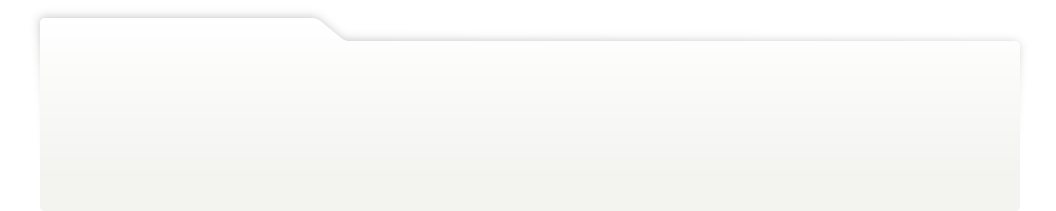
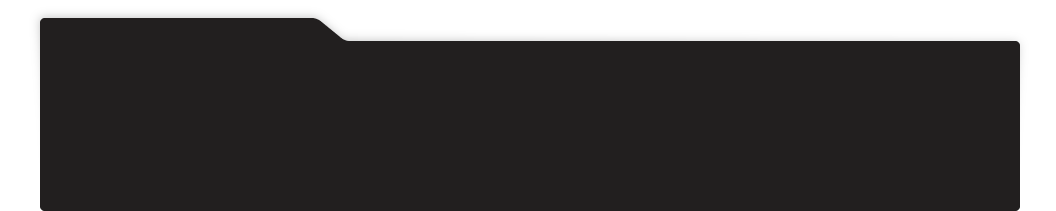
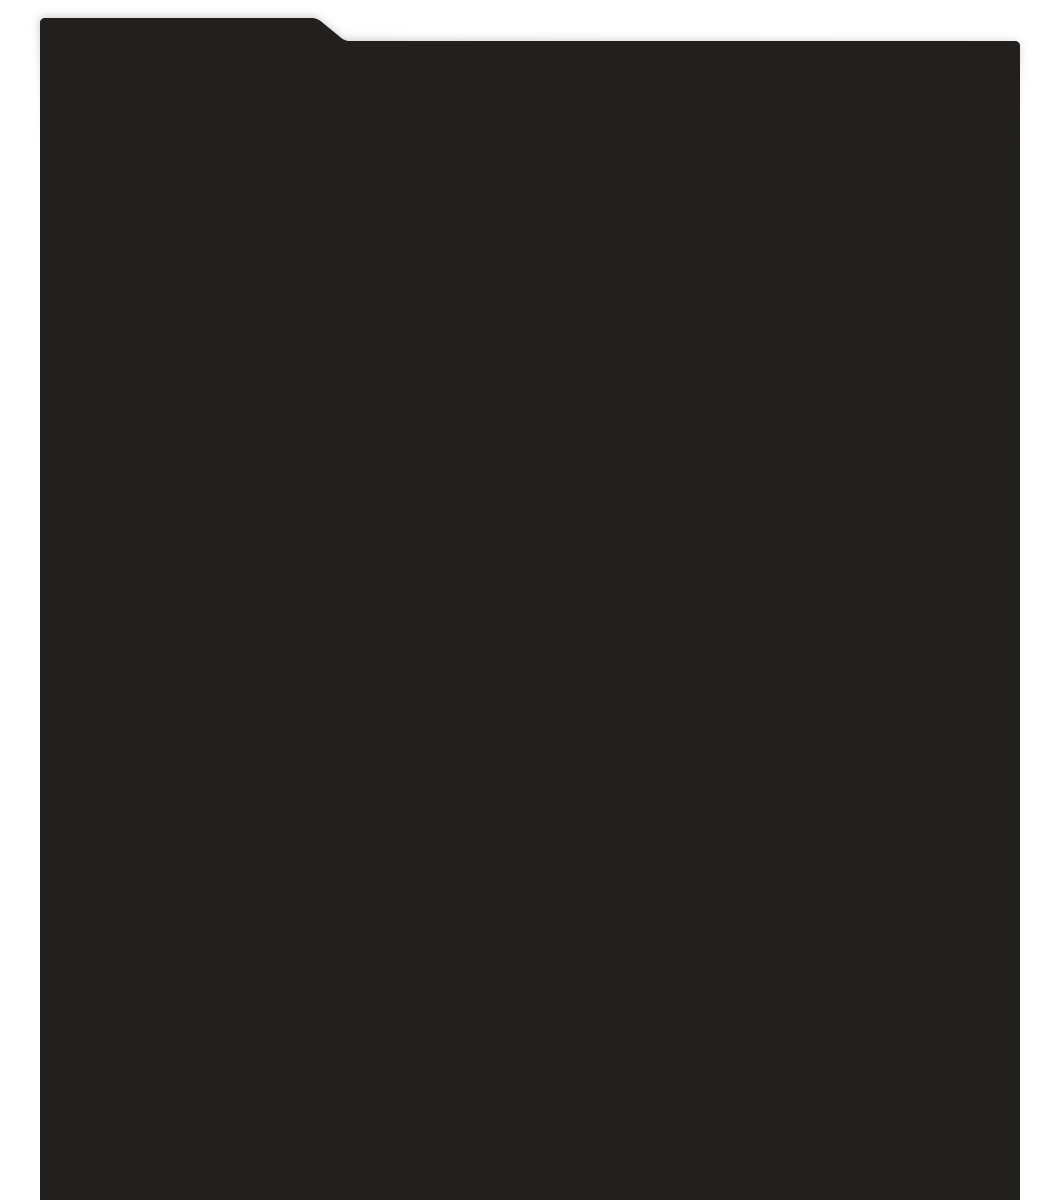
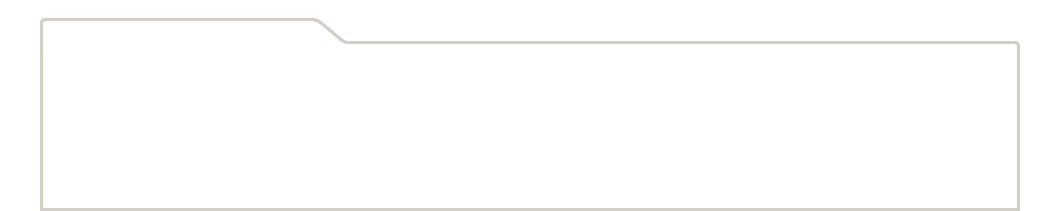
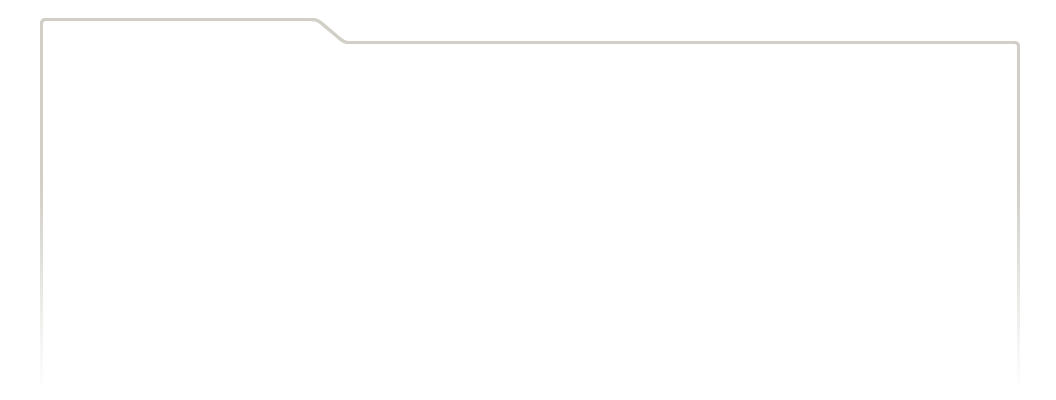
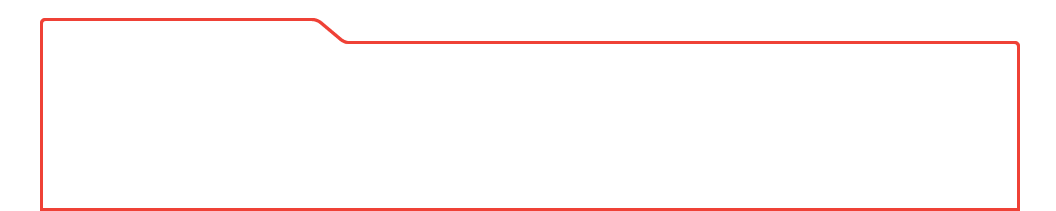
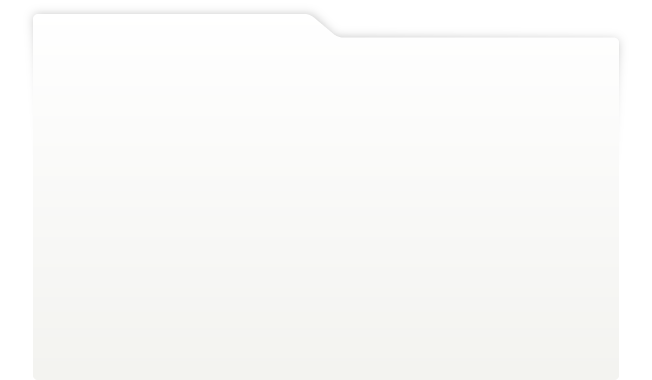
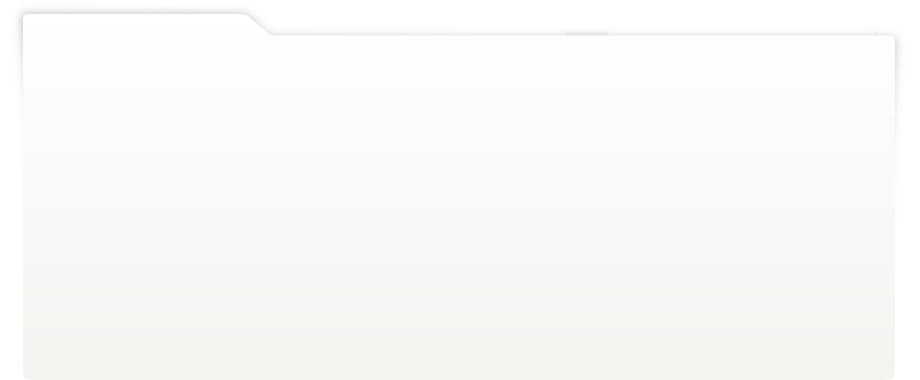
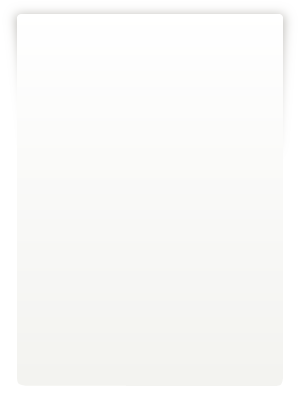
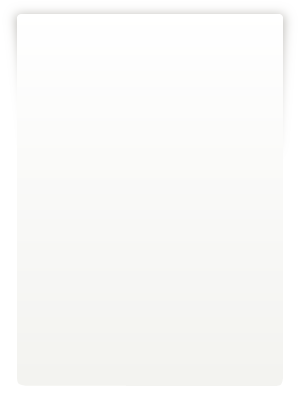
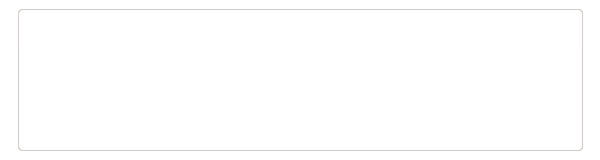
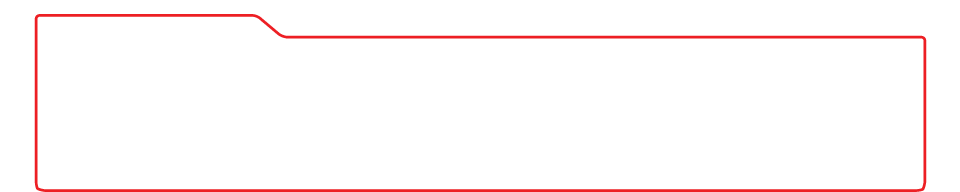
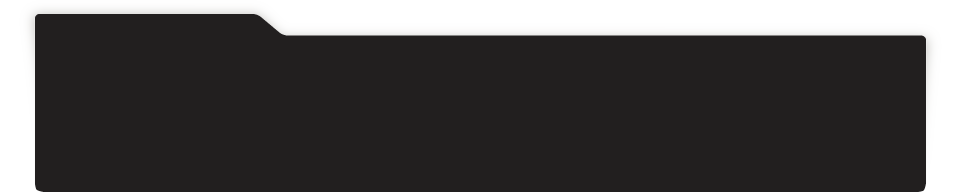
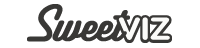
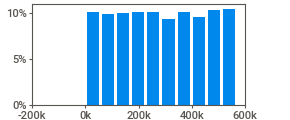
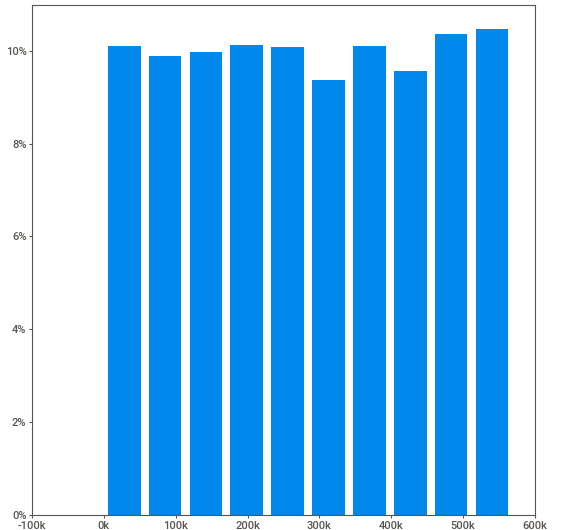
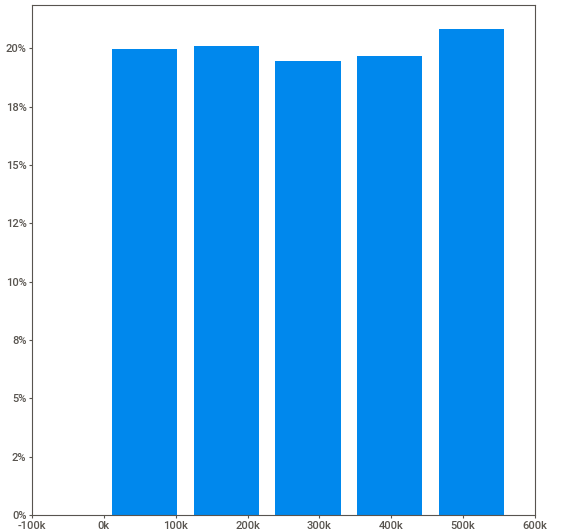
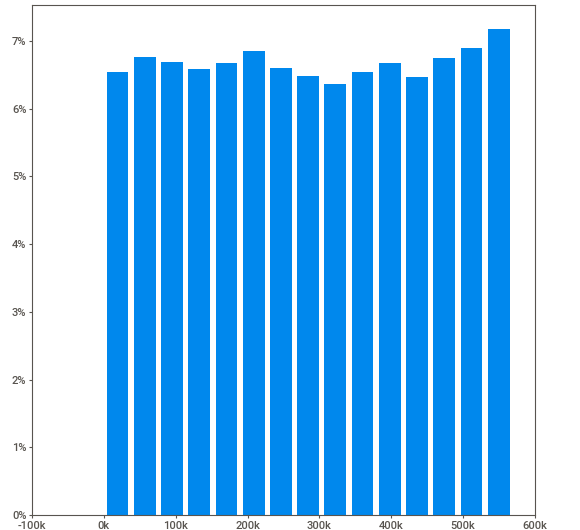
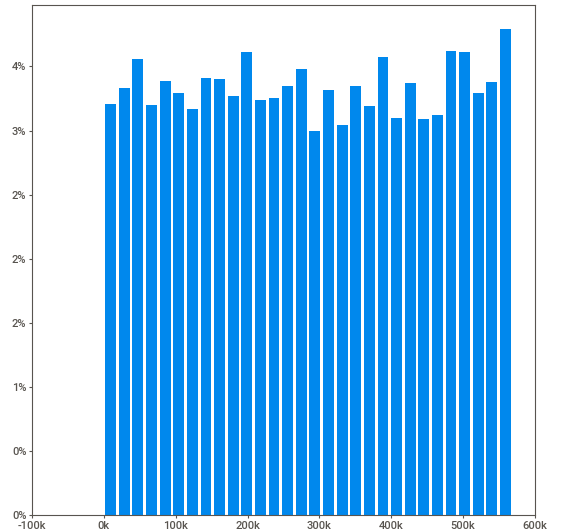
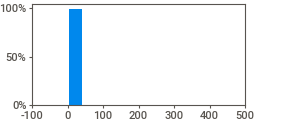
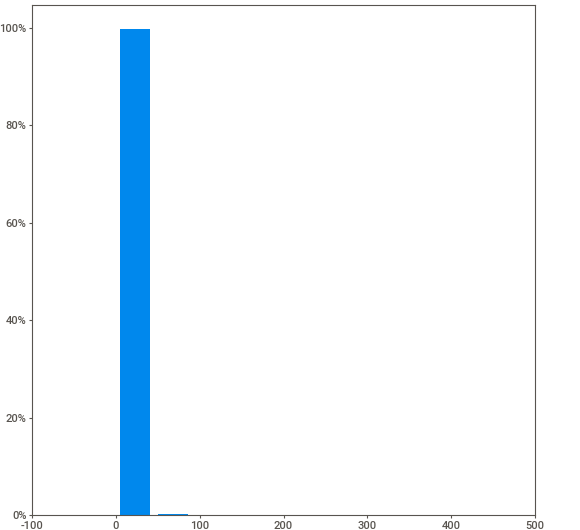
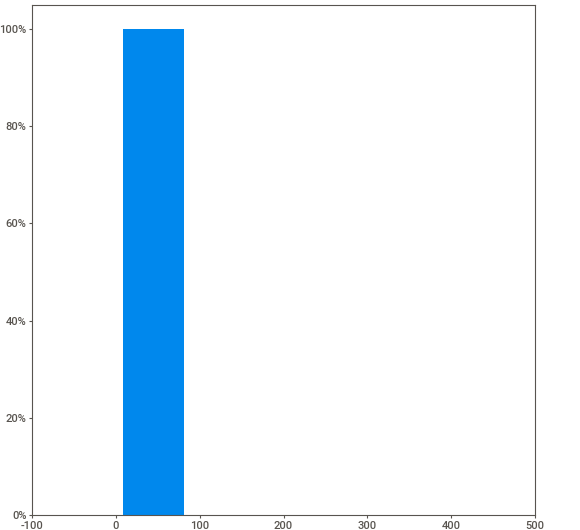
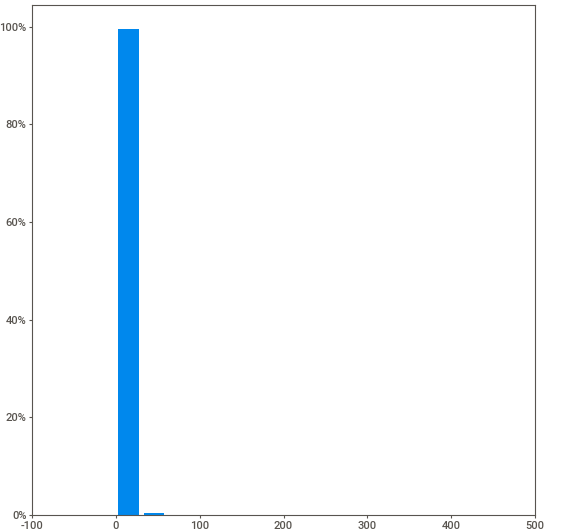
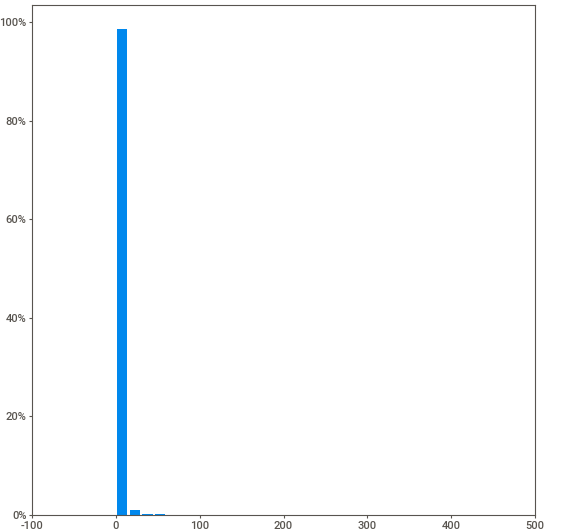
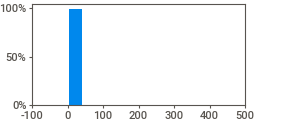
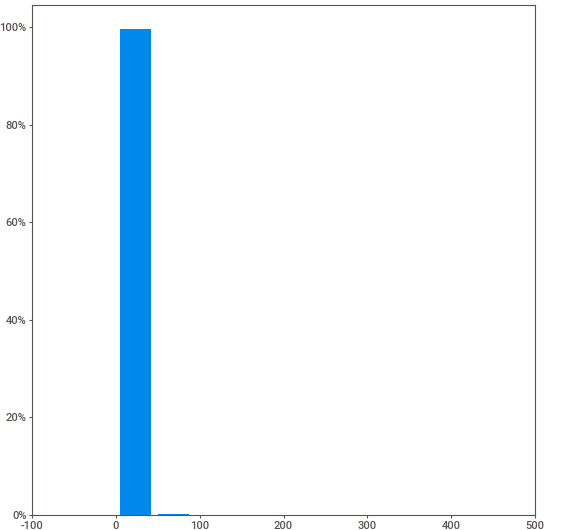
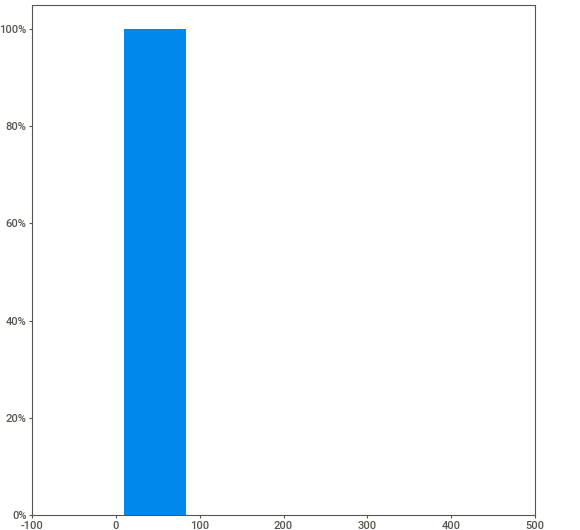
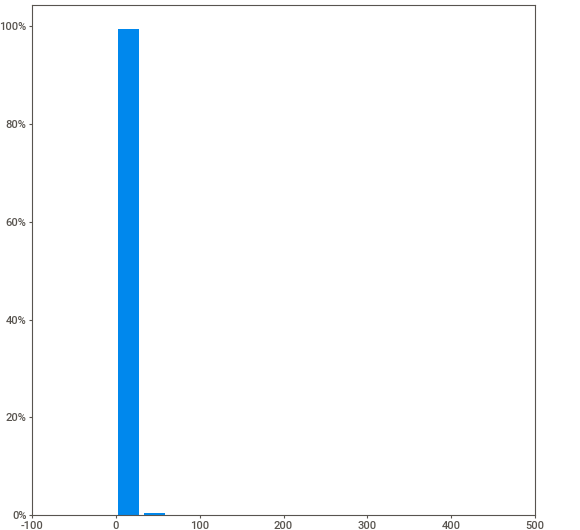
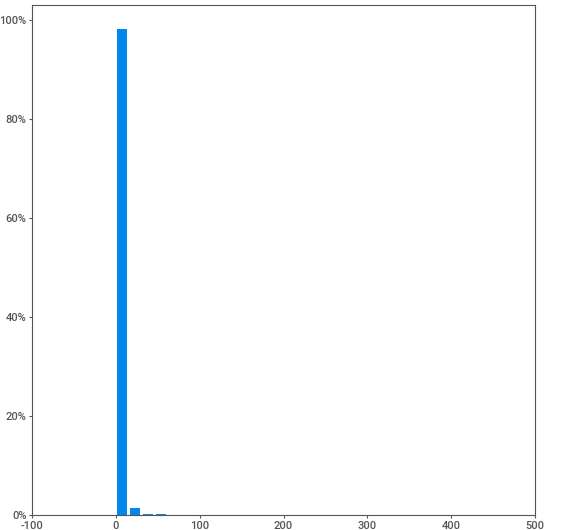
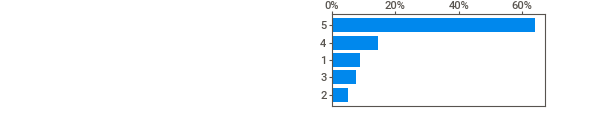
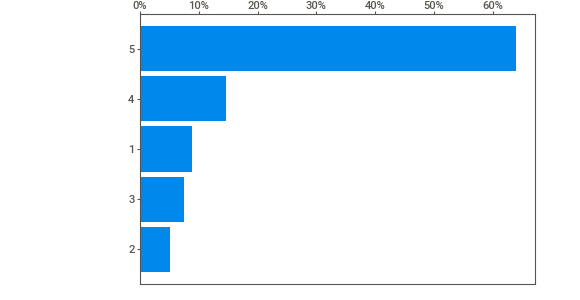
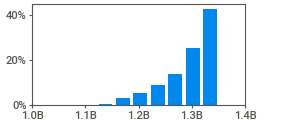
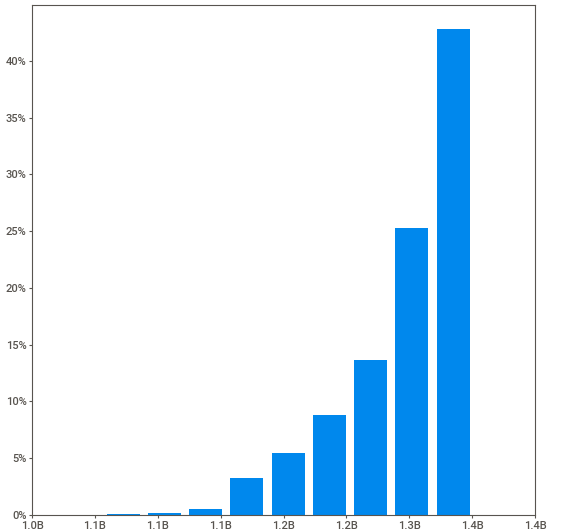
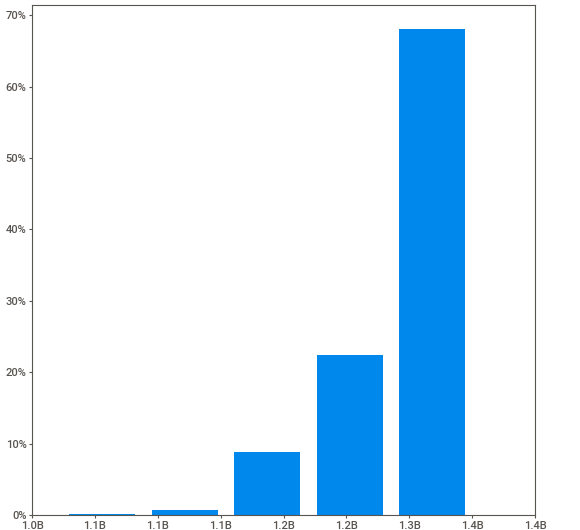
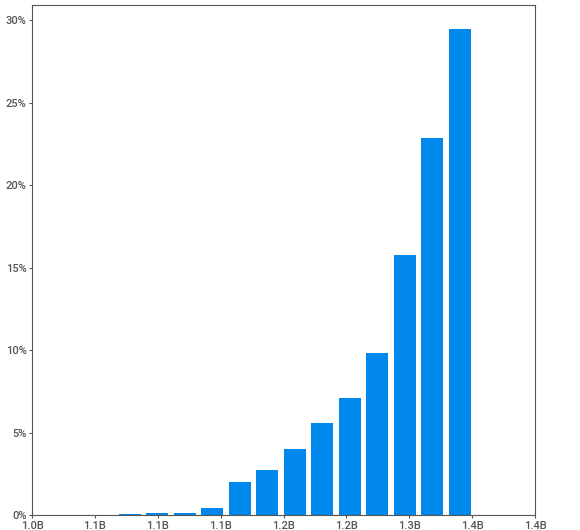
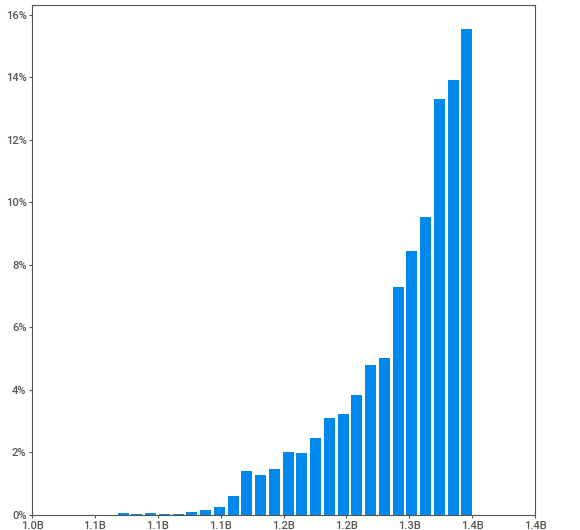
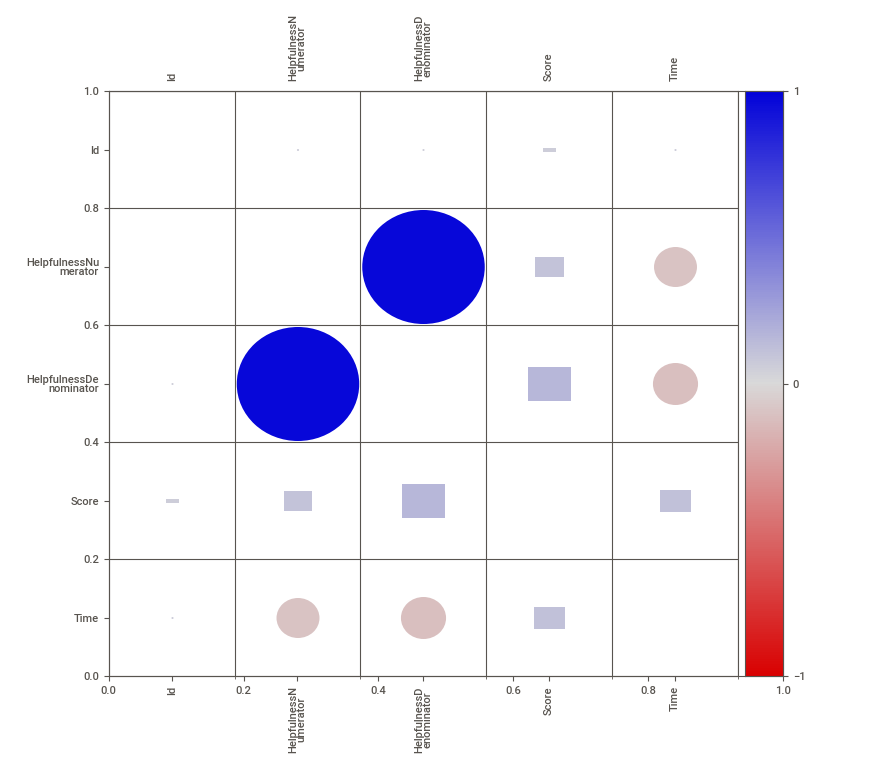
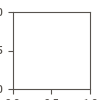

In [ ]:
# EDA automático usando la libreria sweetviz
sample_df = df.sample(n=10000, random_state=42)

report = sv.analyze(sample_df)
report.show_notebook()

In [ ]:
# Descargar stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# 2. LIMPIEZA BÁSICA

# Eliminamos filas con texto o score faltantes
df = df.dropna(subset=['Text', 'Score'])

# Creamos una columna con la longitud del texto
df['TextLength'] = df['Text'].apply(lambda x: len(x.split()))

# Creamos una proporción de utilidad
df = df[df['HelpfulnessDenominator'] != 0]
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

/tmp/ipython-input-3344312240.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=df, palette='viridis')


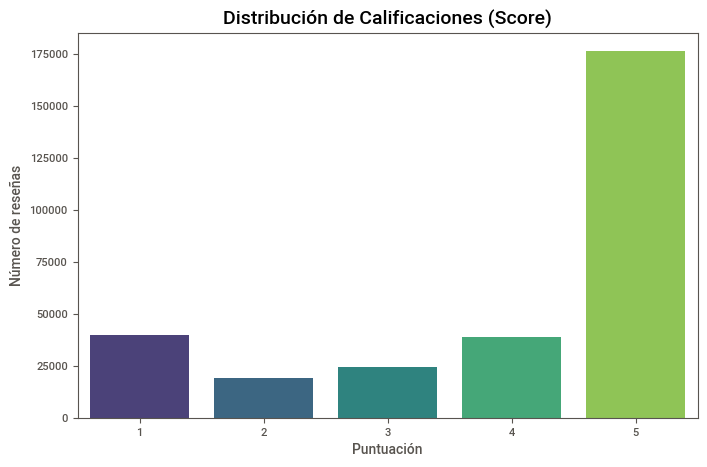

In [ ]:
# 3. DISTRIBUCIÓN DE CALIFICACIONES

plt.figure(figsize=(8,5))
sns.countplot(x='Score', data=df, palette='viridis')
plt.title('Distribución de Calificaciones (Score)', fontsize=14)
plt.xlabel('Puntuación')
plt.ylabel('Número de reseñas')
plt.show()

/tmp/ipython-input-3503680571.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Score', y='HelpfulnessRatio', data=df, palette='coolwarm')


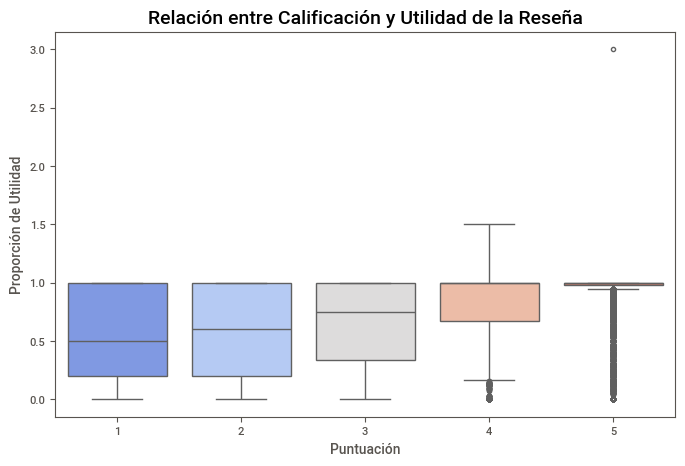

In [ ]:
# 4. RELACIÓN ENTRE UTILIDAD Y CALIFICACIÓN

plt.figure(figsize=(8,5))
sns.boxplot(x='Score', y='HelpfulnessRatio', data=df, palette='coolwarm')
plt.title('Relación entre Calificación y Utilidad de la Reseña', fontsize=14)
plt.xlabel('Puntuación')
plt.ylabel('Proporción de Utilidad')
plt.show()

/tmp/ipython-input-1945013021.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Score', y='TextLength', data=df, palette='magma')


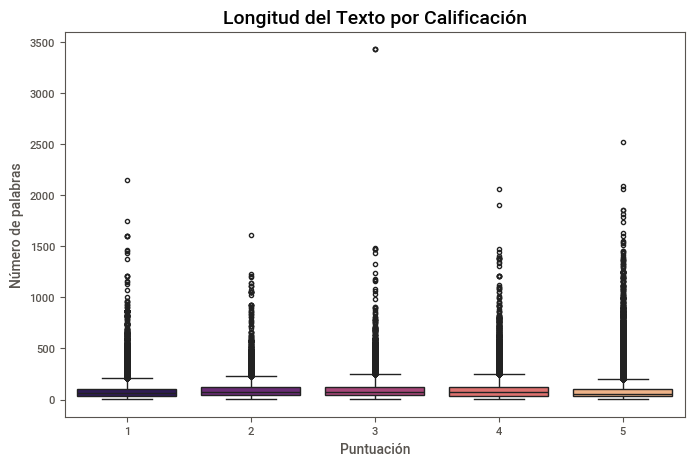

In [ ]:
# 5. LONGITUD DE LAS RESEÑAS

plt.figure(figsize=(8,5))
sns.boxplot(x='Score', y='TextLength', data=df, palette='magma')
plt.title('Longitud del Texto por Calificación', fontsize=14)
plt.xlabel('Puntuación')
plt.ylabel('Número de palabras')
plt.show()

In [ ]:
# 6. LIMPIEZA DE TEXTO PARA WORDCLOUD Y FRECUENCIA

stop_words = set(stopwords.words('english'))

def limpiar_texto(text):
    # 1. Decodificar caracteres HTML (&amp;, &lt;, etc.)
    text = html.unescape(text)
    # 2. Eliminar etiquetas HTML (como <br />)
    text = re.sub(r'<.*?>', ' ', text)
    # 3. Pasar a minúsculas
    text = text.lower()
    # 4. Eliminar números y caracteres no alfabéticos
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 5. Quitar palabras vacías y tokens cortos (1-2 letras)
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)

df['CleanText'] = df['Text'].apply(limpiar_texto)

/tmp/ipython-input-3478199857.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=common_words, palette='crest')


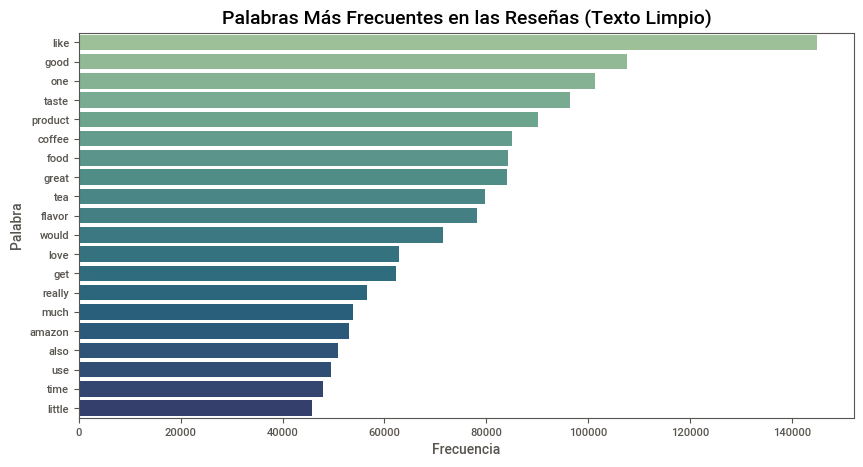

In [ ]:
# 7. FRECUENCIA DE PALABRAS (TOP 20)

# Unir todos los textos
all_words = " ".join(df['CleanText']).split()

# Contar frecuencia
word_freq = Counter(all_words)

# Eliminar tokens residuales (como 'br', 'nbsp', etc.)
for token in ['br', 'nbsp', 'quot', 'http', 'www', 'com']:
    if token in word_freq:
        del word_freq[token]

# Crear DataFrame con top 20
common_words = pd.DataFrame(word_freq.most_common(20), columns=['Palabra', 'Frecuencia'])

plt.figure(figsize=(10,5))
sns.barplot(x='Frecuencia', y='Palabra', data=common_words, palette='crest')
plt.title('Palabras Más Frecuentes en las Reseñas (Texto Limpio)', fontsize=14)
plt.show()

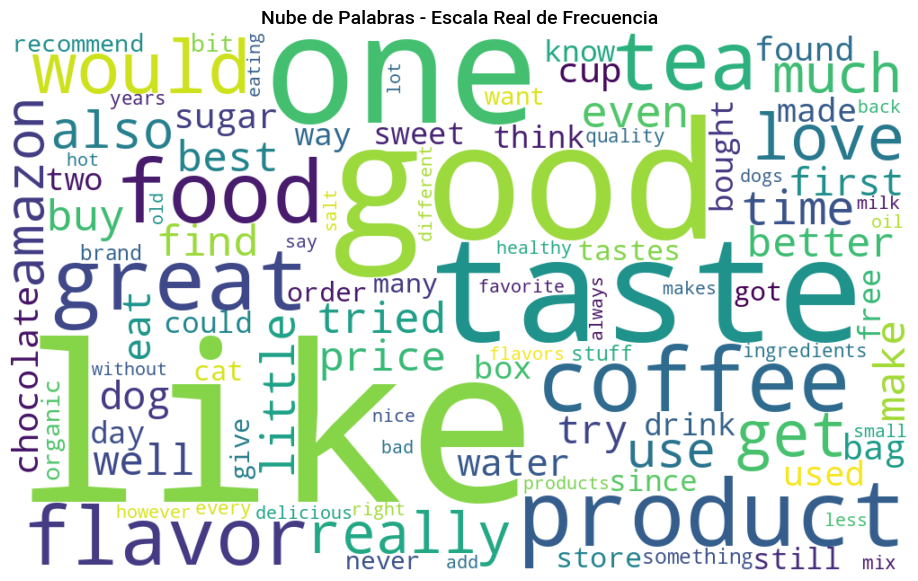

In [ ]:
# 8. NUBE DE PALABRAS (WORD CLOUD)

word_freq_dict = dict(word_freq.most_common(100))

wordcloud = WordCloud(
    width=1000, height=600,
    background_color='white',
    collocations=False,
    stopwords=stop_words,
    relative_scaling=1.0,
    normalize_plurals=False
).generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Escala Real de Frecuencia', fontsize=14)
plt.show()

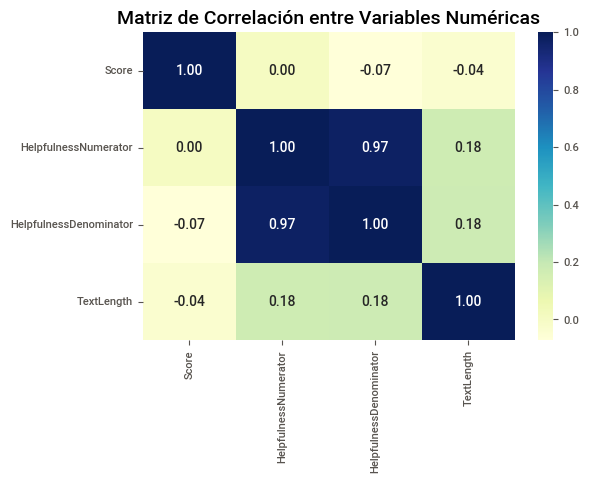

In [ ]:
# 9. CORRELACIÓN ENTRE VARIABLES NUMÉRICAS

numeric_cols = ['Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'TextLength']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=14)
plt.show()

In [ ]:
# Exportar el dataset limpio
df[['Score', 'CleanText']].to_csv('reviews_clean.csv', index=False)
files.download('reviews_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **MODELIZACIÓN**

## **Red Neuronal LSTM (Long Short-Term Memory)**

## Etapa 1 — Cargar datos y preparar conjuntos

In [ ]:
# Cargar el CSV limpio
df = pd.read_csv('reviews_clean.csv')

# Eliminar nulos
df = df.dropna(subset=['CleanText'])

print("Distribución de Score:")
print(df['Score'].value_counts(normalize=True).sort_index())

# Definir variables (Texto crudo y etiquetas originales)
X_raw = df['CleanText']
y_raw = df['Score']

# División inicial
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    stratify=y_raw,
    random_state=42
)

print(f"\nTamaño del conjunto de entrenamiento: {X_train_raw.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test_raw.shape[0]}")

Distribución de Score:
Score
1    0.134058
2    0.064227
3    0.081158
4    0.129490
5    0.591068
Name: proportion, dtype: float64

Tamaño del conjunto de entrenamiento: 238715
Tamaño del conjunto de prueba: 59679


In [ ]:
# 1. Preprocesamiento
print(f"Usando el dataset completo: {len(df)} filas.")

# Definir parámetros
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 100

# Tokenización
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['CleanText'].values)

X_lstm = tokenizer.texts_to_sequences(df['CleanText'].values)
X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)

# Preparar Target
le = LabelEncoder()
y_lstm = le.fit_transform(df['Score'])
y_lstm_cat = to_categorical(y_lstm)

# Split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm_cat,
    test_size=0.2,
    stratify=y_lstm,
    random_state=42
)

# 2. Arquitectura LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_lstm.shape[1]))
model_lstm.add(SpatialDropout1D(0.2))

model_lstm.add(LSTM(100, dropout=0.2))
model_lstm.add(Dense(5, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm.summary())

# 3. Entrenamiento
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=2,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# 4. Evaluacion
accr = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

# Predicciones
y_pred_lstm_probs = model_lstm.predict(X_test_lstm)
y_pred_lstm_classes = np.argmax(y_pred_lstm_probs, axis=1) + 1
y_test_lstm_classes = np.argmax(y_test_lstm, axis=1) + 1

<>:10: SyntaxWarning: invalid escape sequence '\]'
<>:10: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-1114291430.py:10: SyntaxWarning: invalid escape sequence '\]'
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)


Usando el dataset completo: 298394 filas.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/2
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.6653 - loss: 0.9382 - val_accuracy: 0.7243 - val_loss: 0.7525
Epoch 2/2
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.7433 - loss: 0.7037 - val_accuracy: 0.7471 - val_loss: 0.7119
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7451 - loss: 0.7174
Test set
  Loss: 0.714
  Accuracy: 0.746
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


In [ ]:
print("LSTM - Classification Report")
print(classification_report(y_test_lstm_classes, y_pred_lstm_classes, digits=3))

LSTM - Classification Report
              precision    recall  f1-score   support

           1      0.707     0.760     0.732      8001
           2      0.551     0.277     0.368      3833
           3      0.462     0.386     0.420      4843
           4      0.558     0.277     0.370      7728
           5      0.808     0.946     0.872     35274

    accuracy                          0.746     59679
   macro avg      0.617     0.529     0.552     59679
weighted avg      0.718     0.746     0.719     59679



## Etapa 3 — Matriz de confusión y visualización

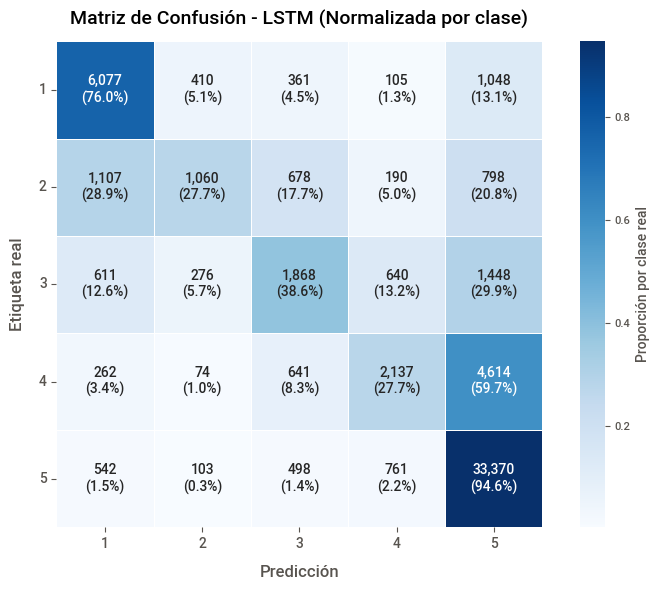

In [ ]:
# Visualización Matriz de Confusión (LSTM)

def plot_confusion_matrix_pretty(y_true, y_pred, labels=None, title="Matriz de Confusión"):
    if labels is None:
        labels = sorted(np.unique(np.concatenate([y_true, y_pred])))

    # Matriz cruda y normalizada por filas
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    # Texto combinado
    annot = np.empty_like(cm).astype(object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            pct = cm_norm[i, j] * 100
            annot[i, j] = f"{cm[i, j]:,}\n({pct:0.1f}%)"

    # Figura
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cm_norm,
        annot=annot,
        fmt="",
        cmap="Blues",
        cbar=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=.5,
        linecolor="white",
        square=True
    )

    # Titulos y ejes
    ax.set_xlabel("Predicción", fontsize=12, labelpad=10)
    ax.set_ylabel("Etiqueta real", fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=14, pad=12)
    plt.xticks(fontsize=10, rotation=0)
    plt.yticks(fontsize=10, rotation=0)
    ax.figure.axes[-1].set_ylabel('Proporción por clase real', rotation=90, fontsize=10)
    plt.tight_layout()
    plt.show()

# Llamada para LSTM
labels_sorted = sorted(df['Score'].unique())
plot_confusion_matrix_pretty(
    y_test_lstm_classes,
    y_pred_lstm_classes,
    labels=labels_sorted,
    title="Matriz de Confusión - LSTM (Normalizada por clase)"
)

In [ ]:
# Guardar el modelo LSTM en un archivo .h5
model_lstm.save('modelo_lstm_entrenado.h5')
print("Modelo LSTM guardado correctamente como 'modelo_lstm_entrenado.h5'")

Modelo LSTM guardado correctamente como 'modelo_lstm_entrenado.h5'


In [ ]:
import pickle

# 1. Guardar el modelo (Cerebro)
model_lstm.save('modelo_lstm_entrenado.h5')

# 2. Guardar el Tokenizer (Diccionario) - ¡MUY IMPORTANTE!
# Sin esto, tu interfaz no sabrá traducir las palabras del usuario.
with open('tokenizer_lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Archivos LSTM guardados:")
print("- modelo_lstm_entrenado.h5")
print("- tokenizer_lstm.pickle")

Archivos LSTM guardados:
- modelo_lstm_entrenado.h5
- tokenizer_lstm.pickle


# Regresión Logística!

## Carga y split estratificado

In [ ]:
# REGRESIÓN LOGÍSTICA (multiclase)

df = pd.read_csv('reviews_clean.csv').dropna(subset=['CleanText'])
X = df['CleanText']
y = df['Score']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

Train: 238715 | Test: 59679


## Baseline: TF-IDF + LogisticRegression

In [ ]:
baseline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        min_df=5
    )),
    ('lr', LogisticRegression(
        solver='saga',
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=2000,
        n_jobs=-1,
        C=1.0,
        penalty='l2'
    ))
])

baseline_lr.fit(X_train, y_train)
y_pred_lr = baseline_lr.predict(X_test)

print("REGRESIÓN LOGÍSTICA - BASELINE")
print(classification_report(y_test, y_pred_lr, digits=3))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


REGRESIÓN LOGÍSTICA - BASELINE
              precision    recall  f1-score   support

           1      0.704     0.734     0.719      8001
           2      0.388     0.545     0.454      3833
           3      0.405     0.536     0.461      4843
           4      0.396     0.553     0.461      7728
           5      0.916     0.746     0.822     35274

    accuracy                          0.690     59679
   macro avg      0.562     0.623     0.583     59679
weighted avg      0.745     0.690     0.709     59679



# Matriz de confusión

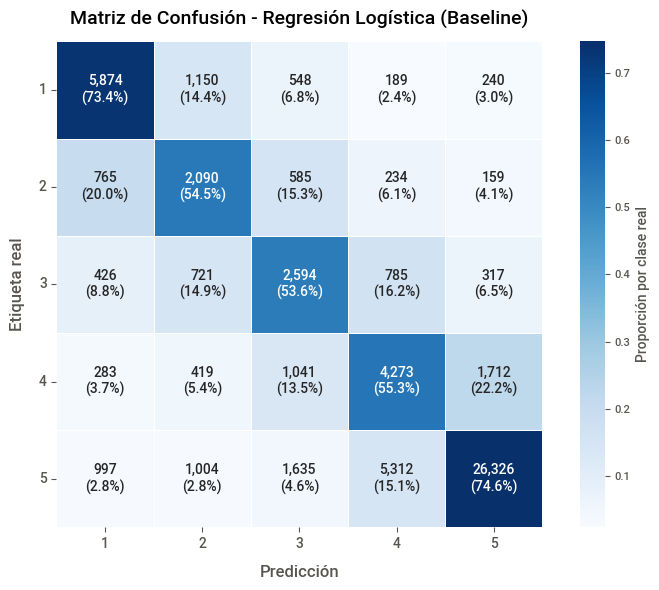

In [ ]:
labels_sorted = sorted(df['Score'].unique())
plot_confusion_matrix_prety = plot_confusion_matrix_pretty

plot_confusion_matrix_pretty(
    y_test, y_pred_lr, labels=labels_sorted,
    title="Matriz de Confusión - Regresión Logística (Baseline)"
)

In [ ]:
# 1. TF-IDF una sola vez

tfidf_fast = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=5
)
X_train_tfidf = tfidf_fast.fit_transform(X_train)
X_test_tfidf  = tfidf_fast.transform(X_test)

# 2. GridSearch mini (solo C) con 3 folds

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_base = LogisticRegression(
    solver='saga',
    multi_class='multinomial',
    class_weight='balanced',
    max_iter=1500,
    n_jobs=-1
)

param_grid_fast = {
    'C': [0.5, 1.0, 2.0]
}

grid_fast = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid_fast,
    scoring='f1_weighted',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid_fast.fit(X_train_tfidf, y_train)

print("Mejores params (rápido):", grid_fast.best_params_)
print("Mejor F1 (cv weighted):", grid_fast.best_score_)

# 3. Evaluación final en test

best_lr_fast = grid_fast.best_estimator_
y_pred_lr_fast = best_lr_fast.predict(X_test_tfidf)

print("\nREGRESIÓN LOGÍSTICA (Quick Tuned)")
print(classification_report(y_test, y_pred_lr_fast, digits=3))


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejores params (rápido): {'C': 2.0}
Mejor F1 (cv weighted): 0.7062747310757519

REGRESIÓN LOGÍSTICA (Quick Tuned)
              precision    recall  f1-score   support

           1      0.707     0.738     0.722      8001
           2      0.394     0.550     0.459      3833
           3      0.413     0.546     0.470      4843
           4      0.404     0.563     0.470      7728
           5      0.917     0.749     0.825     35274

    accuracy                          0.694     59679
   macro avg      0.567     0.629     0.589     59679
weighted avg      0.748     0.694     0.713     59679



In [ ]:
def resumen_metricas(y_true, y_pred, nombre):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (weighted)": f1_score(y_true, y_pred, average='weighted'),
        "Precision (weighted)": precision_score(y_true, y_pred, average='weighted'),
        "Recall (weighted)": recall_score(y_true, y_pred, average='weighted')
    }

tabla = pd.DataFrame([
    resumen_metricas(y_test, y_pred_lr, "LR Baseline"),
    resumen_metricas(y_test, y_pred_lr_fast, "LR Tuned")
]).sort_values(by="F1 (weighted)", ascending=False)

print("\n Comparación LR:")
print(tabla)
tabla.to_csv("lr_metricas.csv", index=False)
print("Guardado: lr_metricas.csv")


 Comparación LR:
        Modelo  Accuracy  F1 (weighted)  Precision (weighted)  \
1     LR Tuned   0.69403       0.712697              0.748103   
0  LR Baseline   0.68964       0.708717              0.744597   

   Recall (weighted)  
1            0.69403  
0            0.68964  
Guardado: lr_metricas.csv


In [ ]:
tfidf_vec = tfidf_fast
lr_clf = best_lr_fast
feature_names = np.array(tfidf_vec.get_feature_names_out())

classes = lr_clf.classes_
coefs = lr_clf.coef_

def top_terms_per_class(coefs, feature_names, k=20):
    out = {}
    for i, cls in enumerate(classes):
        top_idx = np.argsort(coefs[i])[-k:]
        out[int(cls)] = feature_names[top_idx][::-1].tolist()
    return out

top_terms = top_terms_per_class(coefs, feature_names, k=20)
for cls in sorted(top_terms.keys()):
    print(f"\nTop términos que empujan a Score={cls}:")
    print(", ".join(top_terms[cls]))


Top términos que empujan a Score=1:
worst, terrible, disgusting, awful, one star, threw, zero stars, waste money, yuck, horrible, gross, trash, nasty, rip, disappointed, disappointment, burnt, tasteless, garbage, even

Top términos que empujan a Score=2:
two stars, disappointing, gave two, weak, unfortunately, disappointed, great reviews, hopes, every dog, negative review, plus side, larger dogs, give gifts, disappointment, expires, five days, recieve, various flavors, sadly, sorry

Top términos que empujan a Score=3:
three stars, okay, stars, however, amazon amazon, still tasted, twins, nothing special, tiny amount, decent, see much, contains msg, probably buy, later found, weakness, pretty weak, based experience, petite, since switched, sweet love

Top términos que empujan a Score=4:
four stars, complaint, drawback, stars instead, great, reason give, downside, good, stars, gave four, pleasantly surprised, perfect, nice, bit, delicious, would given, gripe, gave stars, enjoys, tasty



# BERT (Bidirectional Encoder Representations from Transformers)


In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q tf_keras

In [ ]:
# Preparación de Datos y Tokenización para BERT

# Configuracion de compatibilidad
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

# 1. Carga de datos
df_bert = pd.read_csv('reviews_clean.csv')
df_bert = df_bert.dropna(subset=['CleanText'])

SAMPLE_SIZE = 10000
if len(df_bert) > SAMPLE_SIZE:
    print(f"Usando muestra de {SAMPLE_SIZE} registros...")
    df_bert = df_bert.sample(n=SAMPLE_SIZE, random_state=42)

# 2. Variables y Split
X_bert_raw = df_bert['CleanText'].astype(str)
y_bert_labels = df_bert['Score'].values - 1 # Etiquetas 0-4

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bert_raw, y_bert_labels,
    test_size=0.2,
    stratify=y_bert_labels,
    random_state=42
)

# 3. Tokenizacion
print("Cargando Tokenizer...")
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(data, maximum_length):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = tokenizer_bert.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 64
print("Tokenizando datos...")
train_input_ids, train_attention_masks = bert_encode(X_train_b, MAX_LEN)
test_input_ids, test_attention_masks = bert_encode(X_test_b, MAX_LEN)
print("Datos listos")

Usando muestra de 10000 registros...
Cargando Tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizando datos...
Datos listos


In [ ]:
# Entrenamiento del Modelo

# 1. Configurar Modelo
print("Descargando modelo pre-entrenado")
model_bert = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    use_safetensors=False
)

# 2. Compilar
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# 3. Entrenar
print("\nIniciando entrenamiento (Fine-Tuning)")
history_bert = model_bert.fit(
    [train_input_ids, train_attention_masks],
    y_train_b,
    validation_split=0.1,
    epochs=2,
    batch_size=32
)
print("Entrenamiento finalizado")

Descargando modelo pre-entrenado


tf_model.h5:   0%|          | 0.00/536M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Iniciando entrenamiento (Fine-Tuning)
Epoch 1/2
225/225 [==============================] - 243s 561ms/step - loss: 1.0780 - accuracy: 0.6226 - val_loss: 0.9382 - val_accuracy: 0.6600
Epoch 2/2
225/225 [==============================] - 97s 433ms/step - loss: 0.8393 - accuracy: 0.6860 - val_loss: 1.0026 - val_accuracy: 0.6325
Entrenamiento finalizado


Generando predicciones sobre el conjunto de test...
63/63 [==============================] - 13s 140ms/step

REPORT - BERT (Hugging Face)
              precision    recall  f1-score   support

           1      0.441     0.887     0.589       266
           2      0.310     0.094     0.144       139
           3      0.231     0.205     0.217       161
           4      0.361     0.050     0.088       259
           5      0.807     0.854     0.830      1175

    accuracy                          0.649      2000
   macro avg      0.430     0.418     0.374      2000
weighted avg      0.620     0.649     0.605      2000



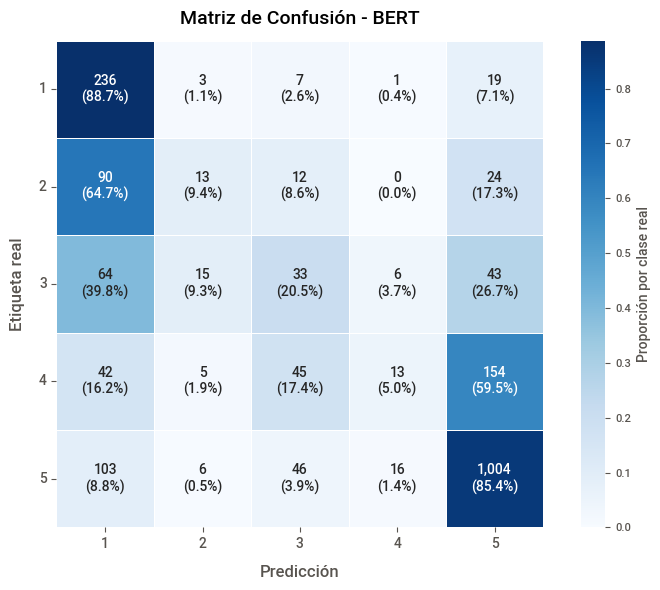

In [ ]:
# Evaluación y Matriz de Confusion

print("Generando predicciones sobre el conjunto de test...")

predict_results = model_bert.predict([test_input_ids, test_attention_masks])
y_pred_bert_logits = predict_results.logits

y_pred_bert = np.argmax(y_pred_bert_logits, axis=1) + 1
y_true_bert = y_test_b + 1

# Reporte de texto
print("\nREPORT - BERT (Hugging Face)")
print(classification_report(y_true_bert, y_pred_bert, digits=3))

# Gráfico de Matriz
try:
    labels_sorted = sorted(df_bert['Score'].unique())
    plot_confusion_matrix_pretty(
        y_true_bert,
        y_pred_bert,
        labels=labels_sorted,
        title="Matriz de Confusión - BERT"
    )
except NameError:
    print("La función de gráfico no está definida. Corre la Celda 3 primero.")

In [ ]:
# Guardado de Metricas

# Calcular metricas
res_bert = {
    "Modelo": "BERT (Hugging Face)",
    "Accuracy": accuracy_score(y_true_bert, y_pred_bert),
    "F1 (weighted)": f1_score(y_true_bert, y_pred_bert, average='weighted'),
    "Precision (weighted)": precision_score(y_true_bert, y_pred_bert, average='weighted'),
    "Recall (weighted)": recall_score(y_true_bert, y_pred_bert, average='weighted')
}

# Crear DataFrame y mostrar
tabla_bert = pd.DataFrame([res_bert])
print("\nResumen de Métricas BERT:")
print(tabla_bert)

# Guardar CSV
tabla_bert.to_csv("bert_metricas.csv", index=False)
print("Guardado: bert_metricas.csv")


Resumen de Métricas BERT:
                Modelo  Accuracy  F1 (weighted)  Precision (weighted)  \
0  BERT (Hugging Face)    0.6495       0.604927              0.619678   

   Recall (weighted)  
0             0.6495  
Guardado: bert_metricas.csv


In [ ]:
# Guardar el modelo BERT (y su tokenizer)
output_dir = './modelo_bert_entrenado'
model_bert.save_pretrained(output_dir)
tokenizer_bert.save_pretrained(output_dir)

print(f"Modelo BERT y tokenizer guardados en el directorio: {output_dir}")

import shutil
shutil.make_archive('modelo_bert_entrenado', 'zip', output_dir)
print("Archivo 'modelo_bert_entrenado.zip' creado y listo para descargar.")

Modelo BERT y tokenizer guardados en el directorio: ./modelo_bert_entrenado
Archivo 'modelo_bert_entrenado.zip' creado y listo para descargar.


# **6. TUNING DE HIPERPARÁMETRO**

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from transformers import TFBertForSequenceClassification

# LSTM

In [ ]:
# TUNING DE LSTM (RED NEURONAL)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

print("INICIANDO TUNING: LSTM ")

# 1. Función para construir modelo
def build_and_train_lstm(units, dropout_rate, epochs=2):
    model = Sequential()

    model.add(Embedding(input_dim=20000, output_dim=100, input_length=150))
    model.add(SpatialDropout1D(0.2))

    model.add(LSTM(units, dropout=dropout_rate))

    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrenamos
    history = model.fit(X_train_lstm, y_train_lstm,
                        epochs=epochs,
                        batch_size=128,
                        validation_split=0.1,
                        verbose=0)

    val_acc = max(history.history['val_accuracy'])
    return val_acc, model

# 2. Configuraciones
lstm_configs = [
    {'units': 64, 'dropout': 0.2},
    {'units': 100, 'dropout': 0.3}
]

best_lstm_acc = 0
best_lstm_config = {}

# 3. Bucle de Experimentación
if 'X_train_lstm' in globals() and 'y_train_lstm' in globals():
    for config in lstm_configs:
        print(f"Probando config: {config}...")
        try:
            acc, _ = build_and_train_lstm(config['units'], config['dropout'])
            print(f" -> Accuracy Val: {acc:.4f}")

            if acc > best_lstm_acc:
                best_lstm_acc = acc
                best_lstm_config = config
        except Exception as e:
            print(f"Error en config {config}: {e}")

    print(f"\nMejor configuracion LSTM: {best_lstm_config}")
    print(f"Mejor Accuracy LSTM: {best_lstm_acc:.4f}")
else:
    print("ERROR: No se encontraron 'X_train_lstm' o 'y_train_lstm'.")

INICIANDO TUNING: LSTM 
Probando config: {'units': 64, 'dropout': 0.2}...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 -> Accuracy Val: 0.7459
Probando config: {'units': 100, 'dropout': 0.3}...
 -> Accuracy Val: 0.7469

Mejor configuracion LSTM: {'units': 100, 'dropout': 0.3}
Mejor Accuracy LSTM: 0.7469


In [ ]:
# TUNING DE LSTM Y GUARDADO

import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

print("INICIANDO TUNING: LSTM ")

# 1. Función para construir modelo
def build_and_train_lstm(units, dropout_rate, epochs=2):
    model = Sequential()

    model.add(Embedding(input_dim=20000, output_dim=100, input_length=150))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(units, dropout=dropout_rate))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrenamos
    history = model.fit(X_train_lstm, y_train_lstm,
                        epochs=epochs,
                        batch_size=128,
                        validation_split=0.1,
                        verbose=0)

    val_acc = max(history.history['val_accuracy'])
    return val_acc, model

# 2. Configuraciones a probar
lstm_configs = [
    {'units': 64, 'dropout': 0.2},
    {'units': 100, 'dropout': 0.3}
]

best_lstm_acc = 0
best_lstm_config = {}

# 3. Bucle de Experimentación
if 'X_train_lstm' in globals() and 'y_train_lstm' in globals():
    for config in lstm_configs:
        print(f"Probando config: {config}...")
        try:
            acc, _ = build_and_train_lstm(config['units'], config['dropout'])
            print(f" -> Accuracy Val: {acc:.4f}")

            if acc > best_lstm_acc:
                best_lstm_acc = acc
                best_lstm_config = config
        except Exception as e:
            print(f"Error en config {config}: {e}")

    print(f"\nMejor configuracion LSTM: {best_lstm_config}")
    print(f"Mejor Accuracy LSTM: {best_lstm_acc:.4f}")

    # GUARDADO DEL MEJOR MODELO
    if best_lstm_config:
        print(f"\n🏆 Re-entrenando el MEJOR modelo LSTM con: {best_lstm_config} para guardarlo...")

        # 4. Volvemos a crear y entrenar el modelo ganador
        final_acc, best_model_lstm = build_and_train_lstm(best_lstm_config['units'], best_lstm_config['dropout'], epochs=2)

        # 5. Guardar el modelo .h5
        best_model_lstm.save('tuning_modelo_lstm_entrenado.h5')

        # 6. Guardar el Tokenizer
        if 'tokenizer' in globals():
            with open('tuning_tokenizer_lstm.pickle', 'wb') as handle:
                pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print("Tokenizer guardado correctamente.")
        else:
            print("ADVERTENCIA: No se encontró la variable 'tokenizer'. El archivo pickle no se creó.")

        print("Archivo del modelo guardado:")
        print("- tuning_modelo_lstm_entrenado.h5")
        print("- tuning_tokenizer_lstm.pickle")

else:
    print("ERROR: No se encontraron 'X_train_lstm' o 'y_train_lstm'.")

INICIANDO TUNING: LSTM 
Probando config: {'units': 64, 'dropout': 0.2}...
 -> Accuracy Val: 0.7492
Probando config: {'units': 100, 'dropout': 0.3}...
 -> Accuracy Val: 0.7445

Mejor configuracion LSTM: {'units': 64, 'dropout': 0.2}
Mejor Accuracy LSTM: 0.7492

🏆 Re-entrenando el MEJOR modelo LSTM con: {'units': 64, 'dropout': 0.2} para guardarlo...


✅ Tokenizer guardado correctamente.
✅ Archivo del modelo guardado:
- tuning_modelo_lstm_entrenado.h5
- tuning_tokenizer_lstm.pickle


# REGRESION LOGISTICA


In [ ]:
# TUNING DE REGRESION LOGISTICA

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

print("INICIANDO TUNING: REGRESION LOGISTICA")

# 1. Definir Espacio de Búsqueda
param_dist_lr = {
    'C': [0.1, 0.5, 1.0, 5.0, 10.0, 50.0],
    'solver': ['saga', 'liblinear'],
    'class_weight': [None, 'balanced'],
    'penalty': ['l2']
}

random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1),
    param_distributions=param_dist_lr,
    n_iter=15,
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 3. Entrenar
if 'X_train_tfidf' in globals() and 'y_train' in globals():
    print(f"Entrenando con X_train_tfidf ({X_train_tfidf.shape})...")
    random_search_lr.fit(X_train_tfidf, y_train)

    # 4. Resultados del Tuning
    best_lr = random_search_lr.best_estimator_
    print(f"\nMejores parametros LR: {random_search_lr.best_params_}")
    print(f"Mejor Score (F1 Weighted) en Validacion: {random_search_lr.best_score_:.4f}")

    # 5. Reporte Final en Test
    if 'X_test_tfidf' in globals() and 'y_test' in globals():
        print("\nEvaluacion en Test Set (Mejor Modelo) ")
        y_pred_tuned = best_lr.predict(X_test_tfidf)
        print(classification_report(y_test, y_pred_tuned, digits=3))

        acc_tuned = accuracy_score(y_test, y_pred_tuned)
        print(f"Accuracy Final en Test: {acc_tuned:.4f}")
    else:
        print("No se encontro X_test_tfidf o y_test para la evaluación final.")

else:
    print("ERROR: No se encontro 'X_train_tfidf'.")

INICIANDO TUNING: REGRESION LOGISTICA
Entrenando con X_train_tfidf ((238715, 20000))...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Mejores parametros LR: {'solver': 'saga', 'penalty': 'l2', 'class_weight': None, 'C': 10.0}
Mejor Score (F1 Weighted) en Validacion: 0.7479

Evaluacion en Test Set (Mejor Modelo) 
              precision    recall  f1-score   support

           1      0.740     0.767     0.754      8001
           2      0.554     0.452     0.498      3833
           3      0.546     0.450     0.493      4843
           4      0.550     0.404     0.466      7728
           5      0.842     0.922     0.880     35274

    accuracy                          0.765     59679
   macro avg      0.647     0.599     0.618     59679
weighted avg      0.748     0.765     0.754     59679

Accuracy Final en Test: 0.7654


In [ ]:
import joblib

# 1. Guardar el mejor modelo encontrado por el RandomizedSearchCV
joblib.dump(best_lr, 'modelo_lr_entrenado.joblib')

# 2. Guardar el vectorizador TF-IDF
joblib.dump(tfidf_fast, 'tfidf_vectorizer.joblib')

print("Archivos guardados correctamente:")
print("- modelo_lr_entrenado.joblib")
print("- tfidf_vectorizer.joblib")

Archivos guardados correctamente:
- modelo_lr_entrenado.joblib
- tfidf_vectorizer.joblib


# BERT

In [ ]:
# TUNING DE HIPERPARÁMETROS: BERT

import tensorflow as tf
from transformers import TFBertForSequenceClassification
import numpy as np

print("INICIANDO TUNING: BERT (Busqueda del mejor Learning Rate)")

# 1. Parámetros a probar
learning_rates = [2e-5, 3e-5]
best_bert_acc = 0
best_lr_bert = 0

# 2. Verificación de variables
if 'train_input_ids' in globals() and 'train_attention_masks' in globals() and 'y_train_b' in globals():

    for lr in learning_rates:
        print(f"\nProbando Learning Rate: {lr}...")
        try:
            # A. Instanciar Modelo limpio
            model_bert_tune = TFBertForSequenceClassification.from_pretrained(
                'bert-base-uncased',
                num_labels=5,
                use_safetensors=False
            )

            # B. Compilación Robusta
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            model_bert_tune.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
            model_bert_tune.optimizer.learning_rate.assign(lr)

            # C. Entrenar
            history_bert = model_bert_tune.fit(
                [train_input_ids, train_attention_masks],
                y_train_b,
                validation_split=0.1,
                epochs=1,
                batch_size=16,
                verbose=1
            )

            # D. Guardar resultado
            val_acc_bert = history_bert.history['val_accuracy'][-1]
            print(f"   -> Accuracy obtenido: {val_acc_bert:.4f}")

            if val_acc_bert > best_bert_acc:
                best_bert_acc = val_acc_bert
                best_lr_bert = lr

            # E. Limpiar memoria
            del model_bert_tune
            tf.keras.backend.clear_session()

        except Exception as e:
            print(f"Error en iteración {lr}: {e}")

    # 3. Resultado Final del Tuning
    print(f" RESULTADO DEL TUNING BERT")
    print(f" Mejor Learning Rate encontrado: {best_lr_bert}")
    print(f" Mejor Accuracy de Validación:   {best_bert_acc:.4f}")

else:
    print(" ERROR: No se encontraron las variables de datos de BERT (train_input_ids, etc).")

INICIANDO TUNING: BERT (Busqueda del mejor Learning Rate)

Probando Learning Rate: 2e-05...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


450/450 [==============================] - 163s 267ms/step - loss: 1.0428 - accuracy: 0.6329 - val_loss: 0.9220 - val_accuracy: 0.6675
   -> Accuracy obtenido: 0.6675

Probando Learning Rate: 3e-05...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


450/450 [==============================] - 163s 268ms/step - loss: 1.0432 - accuracy: 0.6278 - val_loss: 0.9830 - val_accuracy: 0.6263
   -> Accuracy obtenido: 0.6263
 RESULTADO DEL TUNING BERT
 Mejor Learning Rate encontrado: 2e-05
 Mejor Accuracy de Validación:   0.6675


In [ ]:
# TUNING DE HIPERPARÁMETROS: GUARDADO

import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
import numpy as np
import shutil
import os

print("INICIANDO TUNING: BERT (Busqueda del mejor Learning Rate)")

learning_rates = [2e-5, 3e-5]
best_bert_acc = 0
best_lr_bert = 0

if 'train_input_ids' in globals() and 'train_attention_masks' in globals() and 'y_train_b' in globals():

    for lr in learning_rates:
        print(f"\nProbando Learning Rate: {lr}...")
        try:

            model_bert_tune = TFBertForSequenceClassification.from_pretrained(
                'bert-base-uncased',
                num_labels=5,
                use_safetensors=False
            )

            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            model_bert_tune.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
            model_bert_tune.optimizer.learning_rate.assign(lr)

            history_bert = model_bert_tune.fit(
                [train_input_ids, train_attention_masks],
                y_train_b,
                validation_split=0.1,
                epochs=1,
                batch_size=16,
                verbose=1
            )

            val_acc_bert = history_bert.history['val_accuracy'][-1]
            print(f"   -> Accuracy obtenido: {val_acc_bert:.4f}")

            if val_acc_bert > best_bert_acc:
                best_bert_acc = val_acc_bert
                best_lr_bert = lr

            del model_bert_tune
            tf.keras.backend.clear_session()

        except Exception as e:
            print(f"Error en iteración {lr}: {e}")

    print(f"\nRESULTADO DEL TUNING BERT")
    print(f" Mejor Learning Rate encontrado: {best_lr_bert}")
    print(f" Mejor Accuracy de Validación:   {best_bert_acc:.4f}")


    if best_lr_bert > 0:
        print(f"\n Re-entrenando el MEJOR modelo BERT con Learning Rate: {best_lr_bert} para guardar...")

        final_bert_model = TFBertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=5,
            use_safetensors=False
        )

        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        final_bert_model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
        final_bert_model.optimizer.learning_rate.assign(best_lr_bert)

        final_bert_model.fit(
            [train_input_ids, train_attention_masks],
            y_train_b,
            validation_split=0.1,
            epochs=1,
            batch_size=16,
            verbose=1
        )

        output_dir = './NUEVO_tuning_modelo_bert_entrenado'

        final_bert_model.save_pretrained(output_dir)

        print("Guardando Tokenizer...")
        try:
            tokenizer_final = BertTokenizer.from_pretrained('bert-base-uncased')
            tokenizer_final.save_pretrained(output_dir)
            print(" Tokenizer guardado correctamente.")
        except Exception as e:
            print(f" Error crítico guardando tokenizer: {e}")

        shutil.make_archive('NUEVO_tuning_modelo_bert_entrenado', 'zip', output_dir)

        print("\n PROCESO COMPLETADO EXITOSAMENTE.")
        print("Descarga el archivo: NUEVO_tuning_modelo_bert_entrenado.zip")

    else:
        print("No se encontró un learning rate válido para guardar.")

else:
    print(" ERROR: No se encontraron las variables de datos de BERT (train_input_ids, etc).")

INICIANDO TUNING: BERT (Busqueda del mejor Learning Rate)

Probando Learning Rate: 2e-05...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


450/450 [==============================] - 165s 267ms/step - loss: 1.0468 - accuracy: 0.6324 - val_loss: 0.9154 - val_accuracy: 0.6637
   -> Accuracy obtenido: 0.6637

Probando Learning Rate: 3e-05...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


450/450 [==============================] - 164s 266ms/step - loss: 1.0504 - accuracy: 0.6297 - val_loss: 0.8907 - val_accuracy: 0.6650
   -> Accuracy obtenido: 0.6650

RESULTADO DEL TUNING BERT
 Mejor Learning Rate encontrado: 3e-05
 Mejor Accuracy de Validación:   0.6650

🏆 Re-entrenando el MEJOR modelo BERT con Learning Rate: 3e-05 para guardar...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


450/450 [==============================] - 165s 269ms/step - loss: 1.0256 - accuracy: 0.6382 - val_loss: 0.9260 - val_accuracy: 0.6475
Guardando Tokenizer...
✅ Tokenizer guardado correctamente.

✅ PROCESO COMPLETADO EXITOSAMENTE.
Descarga el archivo: NUEVO_tuning_modelo_bert_entrenado.zip
